In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
"""
Testing environment with stable_baselines3 library
"""
import sys
sys.path.append('../')

from stable_baselines3.common.env_checker import check_env
from envs.MO_single_agent_battery_storage_env import BatteryStorageInGridEnv

env = BatteryStorageInGridEnv()

check_env(env)

/home/ubuntu/.conda/envs/sustaingym/lib/python3.9/site-packages/stable_baselines3/common/env_checker.py:272: UserWarning: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) cf https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  warnings.warn(


  0%|          | 0/10 [00:00<?, ?it/s]

agent change:  -1.4177630219502173e-10
price:  72.49957370981791
agent change:  -1.3660010003503847e-10
price:  69.78177621172551
agent change:  -1.3336020923651945e-10
price:  75.39675138031807
agent change:  -1.2525028259088365e-10
price:  78.00317955563712
agent change:  -1.4222783928577103e-10
price:  74.09294486025021
agent change:  -1.1106134308765187e-10
price:  76.29837359426378
agent change:  -1.1991544477181978e-10
price:  68.73776424411615
agent change:  -1.2884744000011435e-10
price:  73.9196523978565
agent change:  -1.3427057976475634e-10
price:  69.6705038608732
agent change:  -1.366921533366167e-10
price:  68.51187926633769
agent change:  -1.4207643640750758e-10
price:  74.09403047160228
agent change:  -1.2474935677238656e-10
price:  67.94012881940193
agent change:  -1.199714040693728e-10
price:  76.00891223314153
agent change:  -1.30465235302302e-10
price:  72.71488470240996
agent change:  -1.2656448889681338e-10
price:  77.72218154493167
agent change:  -1.5617468552271

 10%|█         | 1/10 [00:01<00:13,  1.47s/it]

agent change:  -1.2513738991460932e-10
price:  74.73449719500292
agent change:  -1.4311202487463365e-10
price:  68.79476475076711
agent change:  -1.1349520959192266e-10
price:  81.1684977489836
agent change:  -1.2029482757439433e-10
price:  72.45854243861884
agent change:  -1.3545318460914721e-10
price:  71.51286614418834
agent change:  -1.340043098515006e-10
price:  88.08654502983599
agent change:  -1.1826532641255328e-10
price:  85.04014756012413
agent change:  -1.2587899221368804e-10
price:  71.3106154558018
agent change:  -1.2248287793401877e-10
price:  74.96706094349835
agent change:  -1.2050982764725437e-10
price:  80.34321907719361
agent change:  -1.2064787372966424e-10
price:  74.4398425433349
agent change:  -1.3114684974802878e-10
price:  81.69613194969178
agent change:  -1.366201471257996e-10
price:  68.07486828477546
agent change:  -1.217453256456143e-10
price:  71.4659498688435
agent change:  -1.1967369883204915e-10
price:  65.78782825526147
agent change:  -1.39889516743938

 20%|██        | 2/10 [00:02<00:11,  1.45s/it]

agent change:  -1.2126904240450395e-10
price:  78.94206178899707
agent change:  -1.286673622821016e-10
price:  71.14753158819794
agent change:  -1.3480071387523681e-10
price:  72.13922127912836
agent change:  -1.264945006502227e-10
price:  66.94726297684643
agent change:  -1.2872489407077646e-10
price:  77.81468814459146
agent change:  -1.1457774199937364e-10
price:  76.67446727937339
agent change:  -1.274147992875996e-10
price:  78.09642372465561
agent change:  -1.2625675677479154e-10
price:  77.6634435737862
agent change:  -1.3351580830372514e-10
price:  68.54591755108832
agent change:  -1.2020620578324485e-10
price:  81.638854359119
agent change:  -1.3495634133939442e-10
price:  62.93386193212123
agent change:  -1.2392936452138727e-10
price:  78.95751534864513
agent change:  -1.1917232661473964e-10
price:  77.45900125979944
agent change:  -1.3163175107770018e-10
price:  72.29171138255599
agent change:  -1.4109105107852456e-10
price:  77.0574306053693
agent change:  -1.42817573307534

 30%|███       | 3/10 [00:04<00:10,  1.45s/it]

agent change:  -1.1095619310495052e-10
price:  75.6946414336215
agent change:  -1.157797219049816e-10
price:  83.12705227644928
agent change:  -1.287801448918787e-10
price:  70.32829630534559
agent change:  -1.2703963973229083e-10
price:  79.11790389264537
agent change:  -1.1455766767248063e-10
price:  66.11230911132047
agent change:  -1.2757943857988844e-10
price:  74.3641829421824
agent change:  -1.0935730946695988e-10
price:  70.84567135812854
agent change:  -1.3085030144501669e-10
price:  80.55960941295339
agent change:  -1.0122559473441022e-10
price:  79.11451349010355
agent change:  -1.1736464263010465e-10
price:  76.4691031915983
agent change:  -1.0188921586866803e-10
price:  72.76758302780941
agent change:  -1.31931925903668e-10
price:  72.25012922756534
agent change:  -1.267439021487973e-10
price:  71.43931493710659
agent change:  -1.1444038418489276e-10
price:  69.45220959750809
agent change:  -1.3287543931480526e-10
price:  77.66954090582138
agent change:  -1.381113326501670

 40%|████      | 4/10 [00:05<00:08,  1.45s/it]

agent change:  -1.4465302605105006e-10
price:  66.42686351935468
agent change:  -1.3276843274818336e-10
price:  67.22452524863616
agent change:  -1.3758148358126464e-10
price:  68.68809089426203
agent change:  -1.3530052009185203e-10
price:  69.24655320754381
agent change:  -1.3381624910250495e-10
price:  77.15335722365748
agent change:  -1.2673405987395435e-10
price:  72.0541835349508
agent change:  -1.308333704838163e-10
price:  89.85780407718975
agent change:  -1.1506533830798493e-10
price:  84.63824635888551
agent change:  -1.2479499010075643e-10
price:  72.73947008064361
agent change:  -1.1490756336148933e-10
price:  79.66475766069158
agent change:  -1.2017703533802575e-10
price:  75.51702382729566
agent change:  -1.4360961741390542e-10
price:  78.24730486294345
agent change:  -9.848136204419807e-11
price:  77.52542836939304
agent change:  -1.3281181636646804e-10
price:  75.55650199328679
agent change:  -1.1854767812965688e-10
price:  68.58057357333973
agent change:  -1.1831306993

 50%|█████     | 5/10 [00:07<00:07,  1.44s/it]

agent change:  -1.554583362728974e-10
price:  78.08144137994732
agent change:  -1.3276995800808503e-10
price:  74.70489312927188
agent change:  -1.282760424568339e-10
price:  68.02736982994531
agent change:  -1.5738075940825404e-10
price:  78.08144138175479
agent change:  -1.4200407205627284e-10
price:  69.94842014867167
agent change:  -1.3027005337795457e-10
price:  74.57304033982012
agent change:  -1.2722701610618897e-10
price:  75.87378382422288
agent change:  -1.4318626607138073e-10
price:  70.08987439704568
agent change:  -1.2618156650823314e-10
price:  78.08144138813834
agent change:  -1.1969628113867577e-10
price:  71.54515197197158
agent change:  -1.5090354225013658e-10
price:  78.0814413633466
agent change:  -1.4008197052437953e-10
price:  72.85347719487217
agent change:  -1.1858353196935163e-10
price:  75.8752365328704
agent change:  -1.301497960758101e-10
price:  76.88937036862066
agent change:  -1.2081235949699252e-10
price:  78.0814413629878
agent change:  -1.2599945175312

 60%|██████    | 6/10 [00:08<00:05,  1.44s/it]

agent change:  -1.1895233827807706e-10
price:  72.20804093522352
agent change:  -1.3049722401982743e-10
price:  71.80928286721915
agent change:  -1.3589225782319796e-10
price:  74.22557630389973
agent change:  -1.23859553426751e-10
price:  69.22263936320948
agent change:  -1.320887291509506e-10
price:  75.95838162300039
agent change:  -1.4047888037174824e-10
price:  74.67719202734483
agent change:  -1.2482634403333557e-10
price:  84.1124502421594
agent change:  -1.1402558323487628e-10
price:  84.14829301107531
agent change:  -1.4734620310273133e-10
price:  72.66622513638913
agent change:  -1.4975035650265633e-10
price:  67.31375334909718
agent change:  -1.2367190833006692e-10
price:  85.87510471922478
agent change:  -1.2795572901433607e-10
price:  80.2920799862976
agent change:  -1.4325443849538946e-10
price:  75.77141906322893
agent change:  -1.486427987287049e-10
price:  64.02234917258367
agent change:  -1.2843497508804306e-10
price:  67.53062948130881
agent change:  -1.1706881409098

 70%|███████   | 7/10 [00:10<00:04,  1.45s/it]

agent change:  -1.4801956650163189e-10
price:  68.35505347882713
agent change:  -1.121544206413798e-10
price:  66.24877098400745
agent change:  -9.408148651440142e-11
price:  63.918962518968506
agent change:  -1.2455914850754867e-10
price:  75.21566371315258
agent change:  -1.0579339467112027e-10
price:  79.54670619690316
agent change:  -1.4145118367322868e-10
price:  71.17371320405273
agent change:  -1.049995942136712e-10
price:  74.81554671655306
agent change:  -1.357066824197068e-10
price:  75.51878538944273
agent change:  -1.0191230679746834e-10
price:  71.99840887933927
agent change:  -1.343553316585903e-10
price:  82.9393843542364
agent change:  -1.4354262692754306e-10
price:  82.93938471311837
agent change:  -1.5487681044979457e-10
price:  69.49259973170221
agent change:  -1.1424669901904659e-10
price:  68.5013424782853
agent change:  -1.4282633066654048e-10
price:  69.90914415369687
agent change:  -1.3271366484755546e-10
price:  67.97627041731143
agent change:  -1.0403179294881

 80%|████████  | 8/10 [00:11<00:02,  1.45s/it]

agent change:  -1.0629782110000833e-10
price:  75.58338469536835
agent change:  -1.342923934715877e-10
price:  79.32631531508959
agent change:  -1.1028802974860337e-10
price:  71.72764300181818
agent change:  -1.0079936229484203e-10
price:  82.55924410289961
agent change:  -1.2203692043714402e-10
price:  85.14301269329863
agent change:  -1.0692377295089546e-10
price:  76.35924569655057
agent change:  -1.0715901074897278e-10
price:  84.5193966953219
agent change:  -1.191466620352692e-10
price:  74.63508422810213
agent change:  -9.806770031839264e-11
price:  78.93939371865655
agent change:  -9.866313601229875e-11
price:  77.69040180576928
agent change:  -1.2283228420392202e-10
price:  75.3225708547855
agent change:  -1.3370542633522723e-10
price:  76.46402405562198
agent change:  -1.0059163950427299e-10
price:  80.65053316583828
agent change:  -1.0430420654596184e-10
price:  74.27069256546115
agent change:  -1.1953359243199573e-10
price:  69.08253109166505
agent change:  -1.1506890417030

 90%|█████████ | 9/10 [00:13<00:01,  1.46s/it]

agent change:  -1.1128086965915945e-10
price:  75.39710701045905
agent change:  -1.014576557090053e-10
price:  75.71098717061352
agent change:  -1.3057477262515013e-10
price:  78.20286632580782
agent change:  -1.0172996868385595e-10
price:  94.39460973294258
agent change:  -1.2562901915890852e-10
price:  83.63530131426373
agent change:  -1.0704156330336063e-10
price:  78.55893999821706
agent change:  -9.5331379964123e-11
price:  76.87811602194448
agent change:  -1.0972363886208132e-10
price:  70.38815880250894
agent change:  -1.168011242737379e-10
price:  81.28469760735933
agent change:  -1.1070754545641198e-10
price:  75.3298843227279
agent change:  -1.147132125678147e-10
price:  71.48686262480969
agent change:  -1.2284472053933393e-10
price:  78.38639378417369
agent change:  -1.1017361377837507e-10
price:  69.25387060772248
agent change:  -1.2927947946045105e-10
price:  67.13511356887153
agent change:  -1.1225704988849046e-10
price:  76.35294033902197
agent change:  -9.24854380301523

100%|██████████| 10/10 [00:14<00:00,  1.45s/it]

agent change:  -1.2479279633358281e-10
price:  82.31299821790562
agent change:  -1.2848207262389298e-10
price:  76.81727592394063
agent change:  -1.3242035396999966e-10
price:  71.93954632425746
agent change:  -1.2821884075222373e-10
price:  75.30495450557565
agent change:  -1.2445090555404285e-10
price:  73.48029560490848
agent change:  -1.209210178281941e-10
price:  73.53623570483366
agent change:  -1.245634504475219e-10
price:  75.16321561937552
agent change:  -1.342688941666133e-10
price:  77.73424836265943
agent change:  -1.381653146485115e-10
price:  79.19323524058925
agent change:  -1.314571062514783e-10
price:  74.09727503681586
agent change:  -1.2610741909247327e-10
price:  75.28810342779082
agent change:  -1.5724123986816443e-10
price:  68.48012057359183
agent change:  -1.1256316965064874e-10
price:  76.27429499147257
agent change:  -1.3070706933781156e-10
price:  70.98539716014469
agent change:  -1.1329293944228674e-10
price:  77.80581155300479
agent change:  -1.274879940991

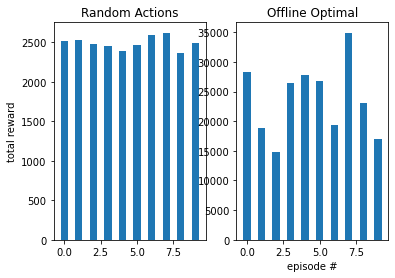

In [3]:
"""
Testing RL agent which randomly chooses actions
"""
import sys
sys.path.append('../')
from typing import List
import numpy as np
import os
import pandas as pd
import gym

from tqdm import tqdm
import matplotlib.pyplot as plt

env = BatteryStorageInGridEnv()

episodes = 10

rewards_lst_1 = []
off_line_rewards_lst_1 = []

for i in tqdm(range(episodes)):
    ob = env.reset()
    done = False
    rewards = np.zeros(env.MAX_STEPS_PER_EPISODE)

    while not done:
        # random action as policy
        action = env.action_space.sample()
        # print("step: ", env.count)
        # print("charging costs: ", env.bats_charge_costs)
        # print("discharging costs: ", env.bats_discharge_costs)
        # print("env load: ", env.load_demand)
        state, reward, done, info = env.step(action)
        rewards[env.count - 1] = reward
    # print("episode {} mean reward: {}".format(i, np.mean(rewards)))
    rewards_lst_1.append(np.sum(rewards))
    off_line_rewards_lst_1.append(env._calculate_off_optimal_total_episode_reward())

# plot episode # versus total episode reward
plt.subplot(1, 2, 1)
plt.bar(list(range(episodes)), rewards_lst_1, width=0.5)
plt.title("Random Actions")

# naming the y axis 
plt.ylabel('total reward')

# plot episode # versus total offline episode reward
plt.subplot(1, 2, 2)
plt.bar(list(range(episodes)), off_line_rewards_lst_1, width=0.5)
plt.title("Offline Optimal")

# naming the x axis 
plt.xlabel('episode #')

plt.show()

In [23]:
from stable_baselines3.ddpg.policies import MultiInputPolicy
from stable_baselines3.common.noise import OrnsteinUhlenbeckActionNoise
from stable_baselines3 import DDPG

env = BatteryStorageInGridEnv()

# the noise objects for DDPG
# n_actions = env.action_space.shape[-1]
# action_noise = OrnsteinUhlenbeckActionNoise(mean=np.zeros(n_actions), sigma=float(0.5) * np.ones(n_actions))

# model = DDPG(MultiInputPolicy, env, action_noise=action_noise, verbose=1)
model = DDPG(MultiInputPolicy, env, verbose=1)
model.learn(total_timesteps=200000)
model.save("ddpg_single_agent_battery_env")

# del model # remove to demonstrate saving and loading

model = DDPG.load("ddpg_single_agent_battery_env")

episodes = 100

rewards_lst_2 = []

for i in tqdm(range(episodes)):
    obs = env.reset()
    done = False
    start = True
    rewards = np.zeros(env.MAX_STEPS_PER_EPISODE)
    avg = np.zeros(1)
    while not done:
        action, _states = model.predict(obs)
        obs, reward, done, info = env.step(action)
        rewards[env.count - 1] = reward
    rewards_lst_2.append(np.sum(rewards))

# plot episode # versus total episode reward
plt.bar(list(range(episodes)), rewards_lst_2)

# naming the x axis 
plt.xlabel('episode #') 
# naming the y axis 
plt.ylabel('total reward')

plt.show()

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


AssertionError: 

100%|██████████| 100/100 [01:22<00:00,  1.22it/s]


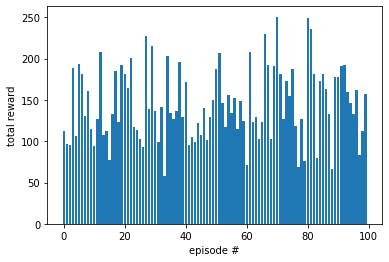

In [21]:
from stable_baselines3 import PPO

env = BatteryStorageInGridEnv()

# model = PPO("MultiInputPolicy", env, verbose=1)
# model.learn(total_timesteps=200000)
# model.save("ppo_single_agent_battery_env")

# del model # remove to demonstrate saving and loading

model = PPO.load("ppo_single_agent_battery_env")

episodes = 100

rewards_lst_4 = []

for i in tqdm(range(episodes)):
    obs = env.reset()
    done = False
    start = True
    rewards = np.zeros(env.MAX_STEPS_PER_EPISODE)
    avg = np.zeros(1)
    while not done:
        action, _states = model.predict(obs)
        if action.shape[0] == 1:
            action = action.reshape((2,))
        obs, reward, done, info = env.step(action)
        rewards[env.count - 1] = reward
    rewards_lst_4.append(np.sum(rewards))

# plot episode # versus total episode reward
plt.bar(list(range(episodes)), rewards_lst_4)

# naming the x axis 
plt.xlabel('episode #') 
# naming the y axis 
plt.ylabel('total reward')

plt.show()